In [1]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools
import gsw                  # compute potential density

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import matplotlib.ticker as ticker

AttributeError: 'dict' object has no attribute 'get_font_properties'

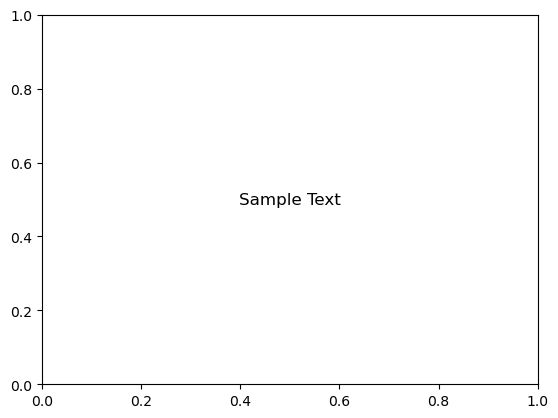

In [158]:
import matplotlib.font_manager as fm

# Create a sample plot with some text
fig, ax = plt.subplots()
ax.text(0.5, 0.5, 'Sample Text', fontsize=12, ha='center', va='center')

# Get the font properties of the rendered text
text_properties = ax.texts[0].properties()
font_properties = text_properties.get_font_properties()

# Print the chosen font
chosen_font = fm.findfont(font_properties)
print(f"Chosen Font: {chosen_font}")

plt.show()

In [2]:
# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 
                             'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

def find_corresponding_number(vvel_filename):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_number_to_find = None
    for filename in vvel_list:
        if filename.split()[1] == vvel_filename:
            vvel_number_to_find = vvel_dict[filename.split()[1]]
            break
    return vvel_number_to_find

def find_corresponding_file_name(vvel_number_to_find):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename

# Load data from 'events_dens_spg.csv' into a NumPy array.
data = np.genfromtxt('events_dens_spg.csv', delimiter=',', names=True, dtype=None)

# Accessing columns by name
member_numbers = data['Index']
events = data['Values']
member_names = []

for i in range(len(member_numbers)):
    member_names.append(find_corresponding_file_name(member_numbers[i])[5:])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Plot Barotropic stream function

In [3]:
filename = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/bsf/bsf_1001.001.nc'
ds_bsf = xr.open_dataset(filename)

# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [15.0, 66.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
maskBSF = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Subpolar Gyre')
maskBSF = maskBSF.sum('region')  
ds_bsf = ds_bsf.where(maskBSF == 1)

In [4]:
# set kwargs
crs = cartopy.crs.PlateCarree()
vmin = -54
vmax = 54
levels = np.linspace(vmin, vmax, 28)
#cmap = cmo.balance
cmap = 'RdBu_r'
extent = [-78, -2, 20, 59]
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',linewidth=0.2, edgecolor='black', facecolor='darkgray')
title = 'Barotropic Streamfunction BSF'
path = '/home/innag3580/phase1_CONDA/results/'
save_name = 'NA_BSF.png'

In [5]:
slice(0, 30)

slice(0, 30, None)

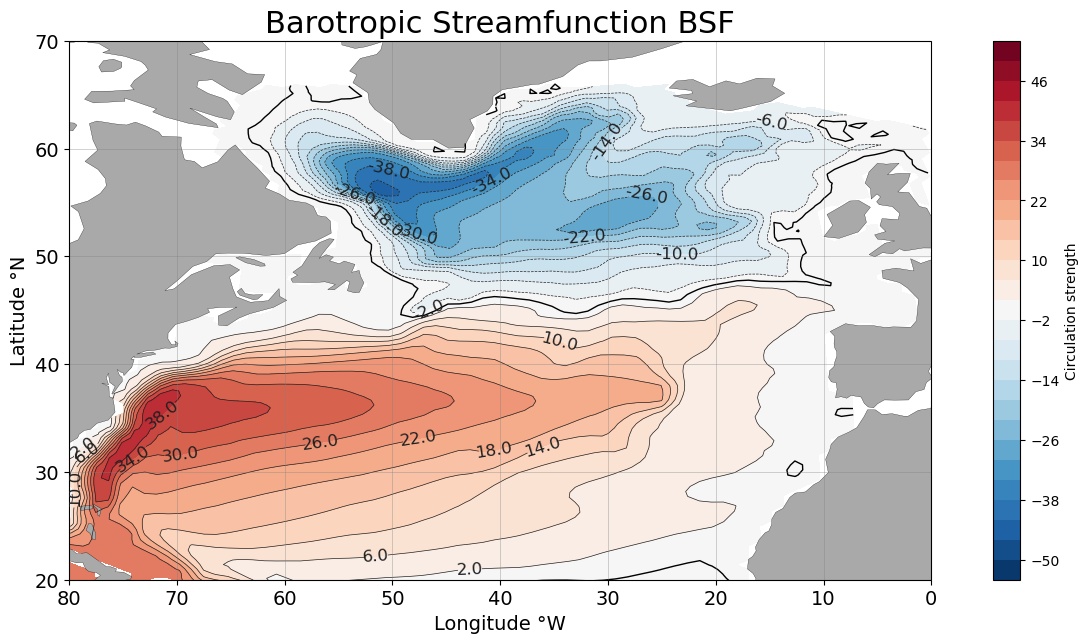

In [6]:
fig = plt.figure(figsize=(16, 7))
ax = plt.axes(projection=crs)
land = ax.add_feature(nature_coast)

ax.set_extent(extent)
ax.set_title(title, fontsize=22)
cf = ax.contourf(ds_bsf.TLONG.roll(nlon=-80), ds_bsf.TLAT.roll(nlon=-80), ds_bsf.BSF.isel(time=slice(0, 30)).mean('time').roll(nlon=-80), levels=levels, cmap=cmap, norm=norm)
cf2 = ax.contour(ds_bsf.TLONG.roll(nlon=-80), ds_bsf.TLAT.roll(nlon=-80), ds_bsf.BSF.isel(time=slice(0, 30)).mean('time').roll(nlon=-80), levels=levels, colors=['#202020', ], linewidths=0.5)
ax.clabel(cf2, inline=True, fontsize=12, fmt='%1.1f')
cf_zero_contour = ax.contour(ds_bsf.TLONG.roll(nlon=-80), ds_bsf.TLAT.roll(nlon=-80), ds_bsf.BSF.isel(time=slice(0, 30)).mean('time').roll(nlon=-80), levels=[0], colors=['black'], linewidths=1, linestyles='solid')
cbar = fig.colorbar(cf, ax=ax)
cbar.ax.set_ylabel('Circulation strength')

# Use MaxNLocator to set the number of ticks
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=9))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# Manually set tick labels
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels([f'{int(abs(tick))}' for tick in xticks], fontsize=14)
ax.set_yticklabels([f'{int(tick)}' for tick in yticks], fontsize=14)
ax.set_ylabel('Latitude °N', fontsize=14)
ax.set_xlabel('Longitude °W', fontsize=14)
ax.gridlines(crs=crs, linewidth=0.5, color='gray', alpha=0.5, linestyle='-', draw_labels={'bottom': False, 'left': False, 'right': False, 'top': False})

#plt.show()
plt.savefig(path+save_name, bbox_inches='tight')

# Plot time series

In [7]:
raw_files = glob.glob(os.path.expanduser('~/phase1_CONDA/')+'timeseries/*time_series.npy')
hist_end = (2014-1850)*12
time_annual = np.arange(1850,1850+(hist_end/12))

signals = np.load(raw_files[7])
signal = signals[:,member_numbers[-3]]

In [8]:
signal = signal[:hist_end]

# Calculate the annual means by averaging the values in each row
reshaped_data = signal.reshape(-1, 12)
annual_mean = np.mean(reshaped_data, axis=1)

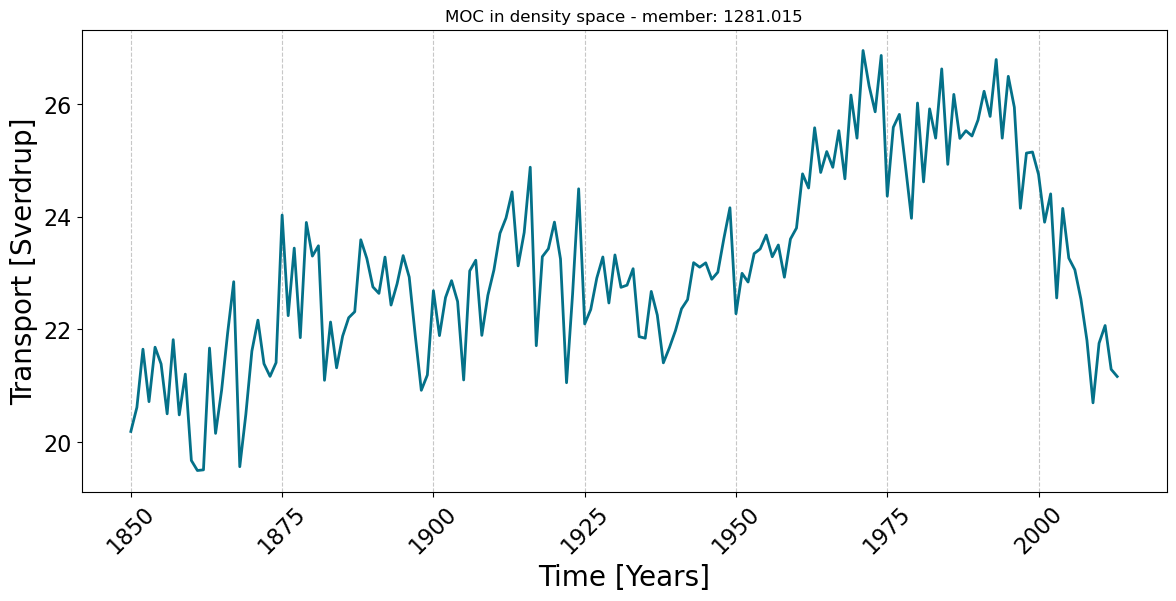

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(time_annual, annual_mean, linewidth=2, color='#047189')
plt.ylabel('Transport [Sverdrup]', fontsize=20)
plt.xlabel('Time [Years]', fontsize=20)
plt.title('MOC in density space - member: '+member_names[-3][:-3])
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.locator_params(axis='x', nbins=8)
plt.locator_params(axis='y', nbins=5)
plt.grid(axis='x', linestyle='--', alpha=0.7)

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'dens_MOC_'+member_names[-3][:-3]+'.png', bbox_inches='tight', dpi=300)

# Plot Composites

In [10]:
ccrs = cartopy.crs

### TEMP

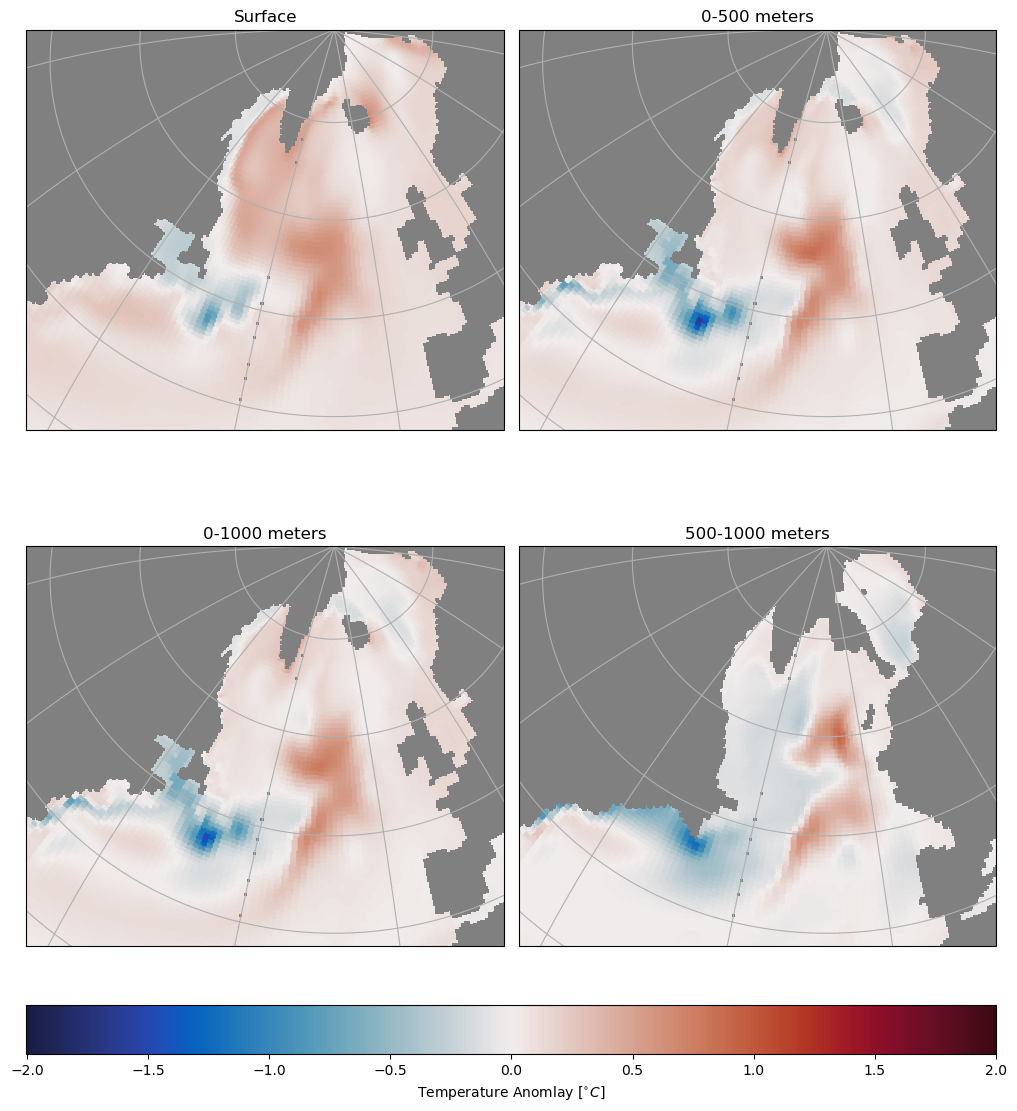

In [137]:
temp_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/temp_anomaly.nc'
difference_temp = xr.open_dataset(temp_file)
vmin = -abs(difference_temp.TEMP).max()
vmax = abs(difference_temp.TEMP).max()
fields = [difference_temp.TEMP.isel(z_t=0).roll(nlon=+100), 
          difference_temp.TEMP.sel(z_t=slice(5.0000000e+02, 5.7937289e+04)).mean('z_t').roll(nlon=+100), 
          difference_temp.TEMP.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t').roll(nlon=+100), 
          difference_temp.TEMP.sel(z_t=slice(5.7937289e+04, 8.7882523e+04)).mean('z_t').roll(nlon=+100)]
names = ['Surface', '0-500 meters', '0-1000 meters', '500-1000 meters']
cmap = cmo.balance
cmap.set_bad('gray')
extent = [-35, 40, 45, 90]

fig, axs = plt.subplots(2, 2, figsize=(10, 15), subplot_kw={'projection': ccrs.Orthographic(15, 65)})
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.set_global()
    ax.gridlines()
    cs = ax.imshow(fields[i], extent=(difference_temp.TLONG.min(), difference_temp.TLONG.max(), difference_temp.TLAT.min(), difference_temp.TLAT.max()),
                   origin='lower', transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_extent(extent)
    ax.set_title(names[i])
plt.tight_layout()
cbar = plt.colorbar(cs, ax=axs, label=r'Temperature Anomlay [$^{\circ}C$]', orientation='horizontal', pad=0.04)
plt.show()

#### Focus plot

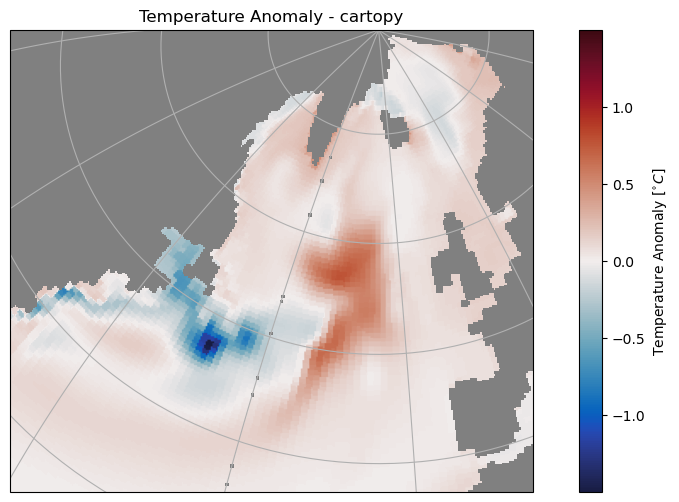

In [143]:
field = difference_temp.TEMP.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t').roll(nlon=+100)
vmin = -abs(field).max()
vmax = abs(field).max()
extent = [-35, 40, 45, 90]
cmap = cmo.balance
cmap.set_bad('gray')


fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Orthographic(20, 65))
ax.set_global()
ax.gridlines()

cs = ax.imshow(field, extent=(difference_temp.TLONG.min(), difference_temp.TLONG.max(), difference_temp.TLAT.min(), difference_temp.TLAT.max()),
               origin='lower', transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_extent(extent)
cbar = plt.colorbar(cs, label=r'Temperature Anomaly [$^{\circ}C$]')
plt.title('Temperature Anomaly - cartopy')

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'temp_anomaly-cartopy.png', bbox_inches='tight', dpi=300)

#### simple plot

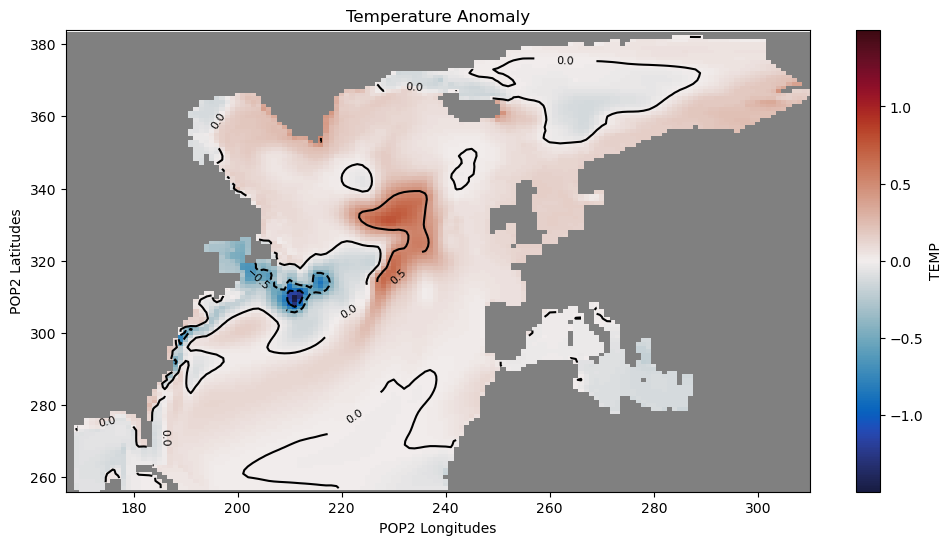

In [144]:
field = difference_temp.TEMP.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t')

cmap = cmo.balance
cmap.set_bad('gray')

plt.figure(figsize=(12, 6))
temp_plot = field.plot(cmap=cmap, vmin=vmin, vmax=vmax)
contour_temp = field.plot.contour(colors='k') 
plt.clabel(contour_temp, inline=True, fontsize=8)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Temperature Anomaly')
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'temp_anomaly-POP.png', bbox_inches='tight', dpi=300)

### SALT

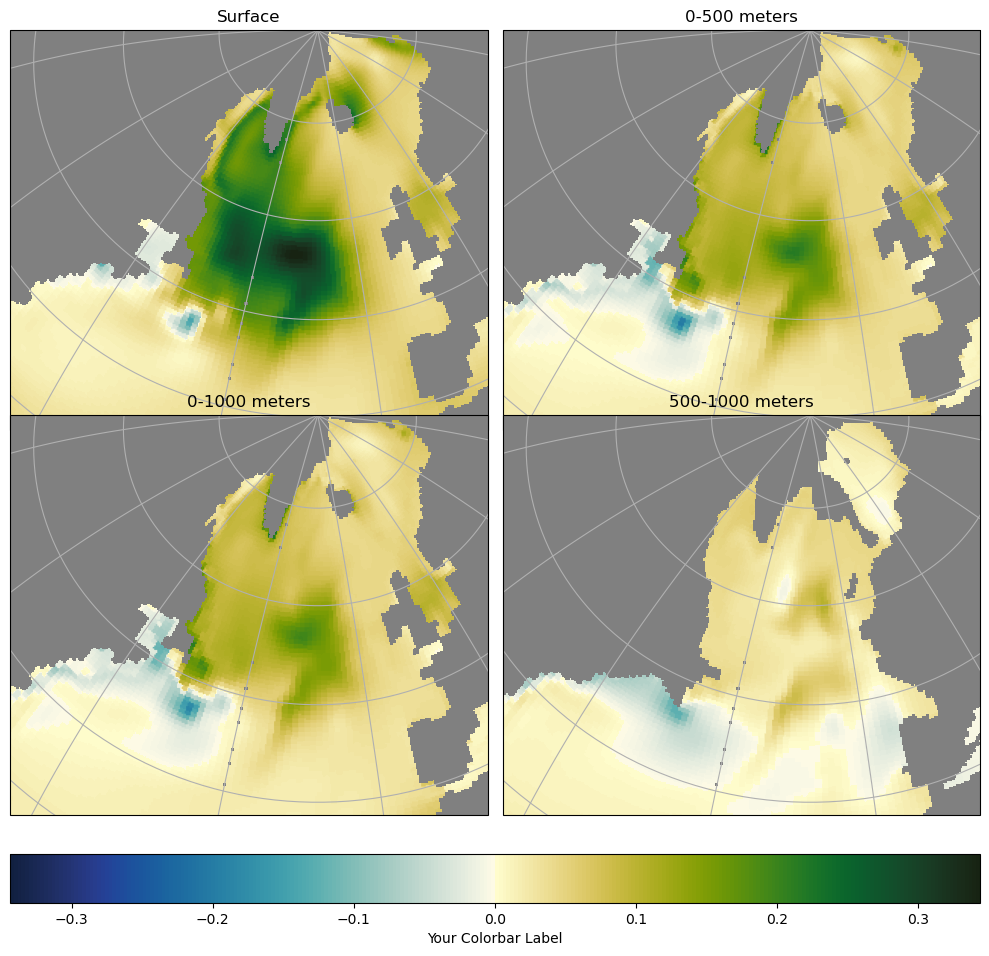

In [145]:
salt_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/salt_anomaly.nc'
difference_salt = xr.open_dataset(salt_file)
vmin = -abs(difference_salt.SALT).max()
vmax = abs(difference_salt.SALT).max()

# Assuming you have four different fields, replace these with your actual data
fields = [difference_salt.SALT.isel(z_t=0).roll(nlon=+100), 
          difference_salt.SALT.sel(z_t=slice(5.0000000e+02, 5.7937289e+04)).mean('z_t').roll(nlon=+100), 
          difference_salt.SALT.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t').roll(nlon=+100), 
          difference_salt.SALT.sel(z_t=slice(5.7937289e+04, 8.7882523e+04)).mean('z_t').roll(nlon=+100)]
names = ['Surface', '0-500 meters', '0-1000 meters', '500-1000 meters']
cmap = cmo.delta
cmap.set_bad('gray')
extent = [-35, 40, 45, 90]

# Set up the figure with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 10), subplot_kw={'projection': ccrs.Orthographic(15, 65)})

# Flatten the axs array for easier indexing
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.set_global()
    ax.gridlines()
    
    # Replace 'fields[i]' with the actual data for each subplot
    cs = ax.imshow(fields[i], extent=(difference_salt.TLONG.min(), difference_salt.TLONG.max(), difference_salt.TLAT.min(), difference_salt.TLAT.max()),
                   origin='lower', transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    
    ax.set_extent(extent)
    ax.set_title(names[i])

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Set colorbar with center around zero
cbar = plt.colorbar(cs, ax=axs, label='Your Colorbar Label', orientation='horizontal', pad=0.04)

plt.show()

### Focus Plot

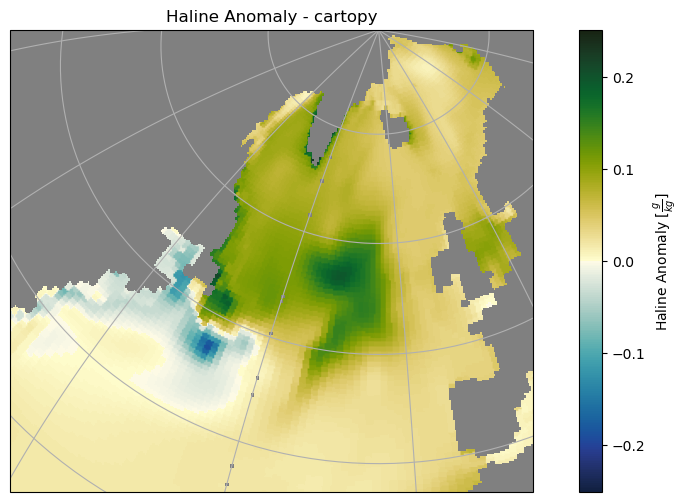

In [146]:
field = difference_salt.SALT.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t').roll(nlon=+100)
vmin = -abs(field).max()
vmax = abs(field).max()
extent = [-35, 40, 45, 90]
cmap = cmo.delta
cmap.set_bad('gray')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Orthographic(20, 65))
ax.set_global()
ax.gridlines()

cs = ax.imshow(field, extent=(difference_salt.TLONG.min(), difference_salt.TLONG.max(), difference_salt.TLAT.min(), difference_salt.TLAT.max()),
               origin='lower', transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_extent(extent)
cbar = plt.colorbar(cs, label=r'Haline Anomaly [$\frac{g}{kg}$]') 
plt.title('Haline Anomaly - cartopy')

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'salt_anomaly-cartopy.png', bbox_inches='tight', dpi=300)

### Simple plot

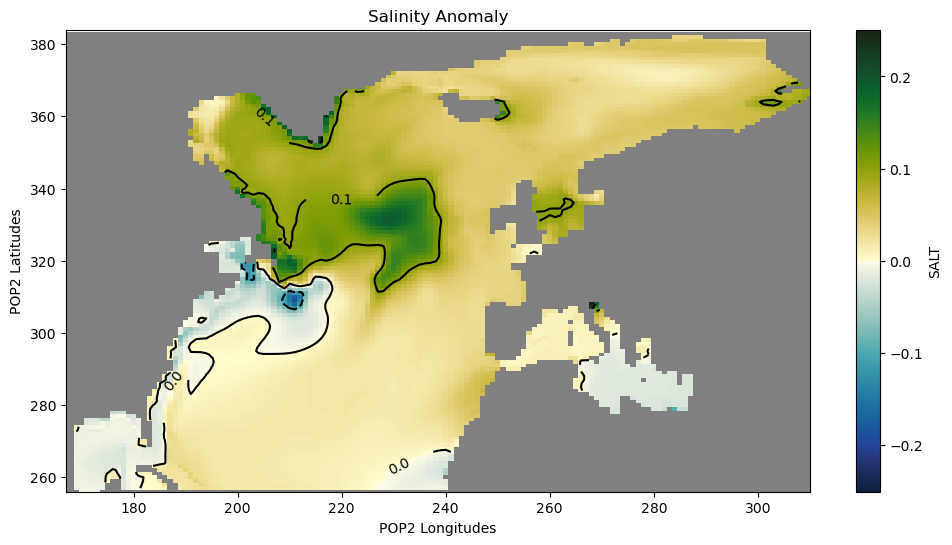

In [147]:
field = difference_salt.SALT.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t')

cmap = cmo.delta
cmap.set_bad('gray')

plt.figure(figsize=(12, 6))
salt_plot = field.plot(cmap=cmap, vmin=vmin, vmax=vmax)
contour_salt = field.plot.contour(colors='k') 
plt.clabel(contour_salt, inline=True, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Salinity Anomaly')
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'salt_anomaly-POP.png', bbox_inches='tight', dpi=300)

### DENS

#### horizontal map

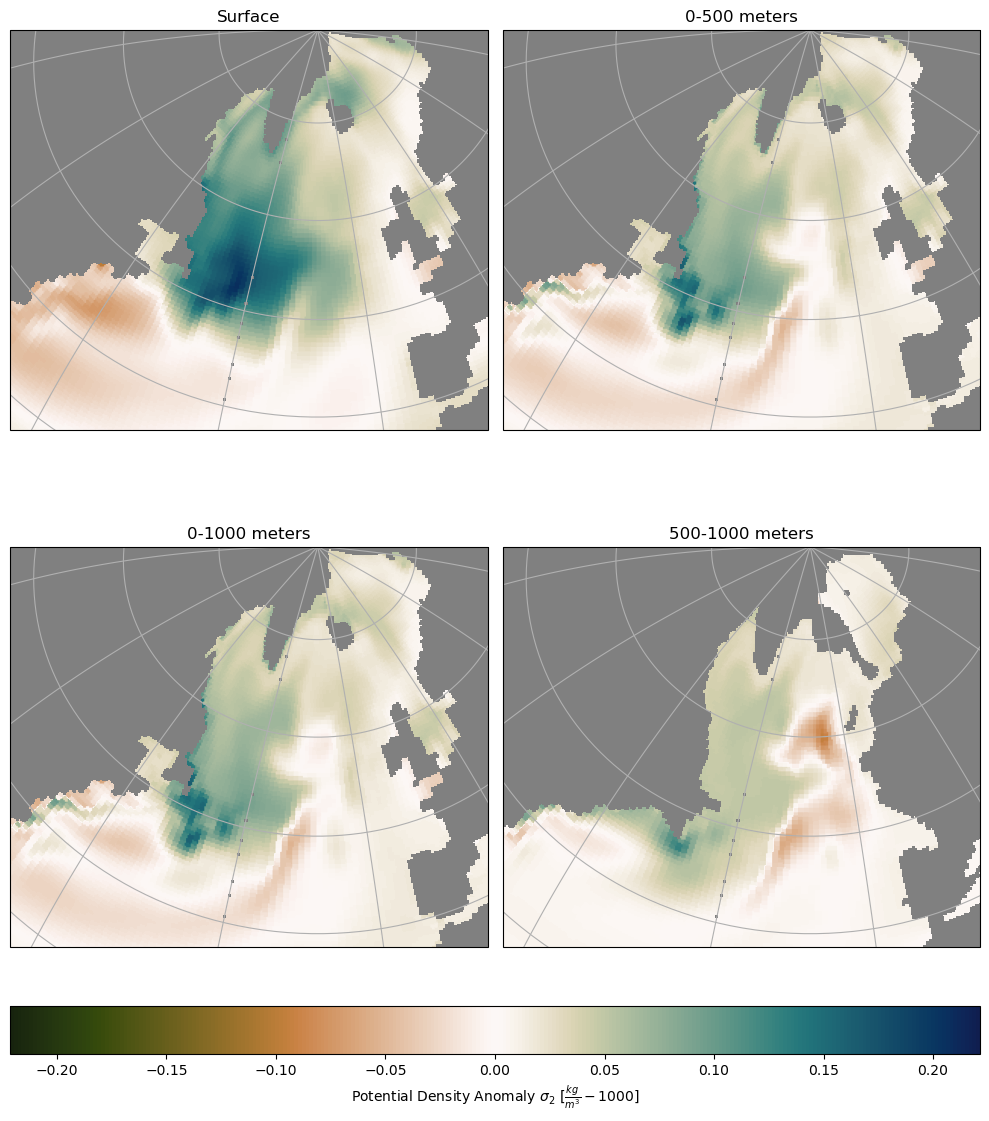

In [156]:
sigma_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/sigma_anomaly.nc'
difference_sigma = xr.open_dataset(sigma_file)
vmin = -abs(difference_sigma.SIGMA_2).max()
vmax = abs(difference_sigma.SIGMA_2).max()
fields = [difference_sigma.SIGMA_2.isel(z_t=0).roll(nlon=+100), 
          difference_sigma.SIGMA_2.sel(z_t=slice(5.0000000e+02, 5.7937289e+04)).mean('z_t').roll(nlon=+100), 
          difference_sigma.SIGMA_2.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t').roll(nlon=+100), 
          difference_sigma.SIGMA_2.sel(z_t=slice(5.7937289e+04, 8.7882523e+04)).mean('z_t').roll(nlon=+100)]
names = ['Surface', '0-500 meters', '0-1000 meters', '500-1000 meters']

cmap = cmo.tarn
cmap.set_bad('gray')
extent = [-35, 40, 45, 90]

fig, axs = plt.subplots(2, 2, figsize=(10, 15), subplot_kw={'projection': ccrs.Orthographic(15, 65)})
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.set_global()
    ax.gridlines()
    cs = ax.imshow(fields[i], extent=(difference_sigma.TLONG.min(), difference_sigma.TLONG.max(), difference_sigma.TLAT.min(), difference_sigma.TLAT.max()),
                   origin='lower', transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_extent(extent)
    ax.set_title(names[i])
plt.tight_layout()
cbar = plt.colorbar(cs, ax=axs, label=r'Potential Density Anomaly $\sigma_2$ [$\frac{kg}{m^3} -1000$]', orientation='horizontal', pad=0.04)
plt.show()

### Focus Plot

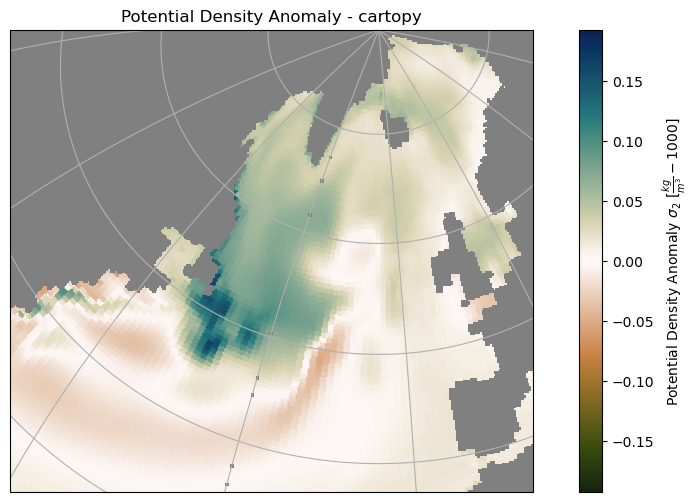

In [148]:
field = difference_sigma.SIGMA_2.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t').roll(nlon=+100)
vmin = -abs(field).max()
vmax = abs(field).max()
extent = [-35, 40, 45, 90]
cmap = cmo.tarn
cmap.set_bad('gray')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Orthographic(20, 65))
ax.set_global()
ax.gridlines()

cs = ax.imshow(field, extent=(difference_sigma.TLONG.min(), difference_sigma.TLONG.max(), difference_sigma.TLAT.min(), difference_sigma.TLAT.max()),
               origin='lower', transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_extent(extent)
cbar = plt.colorbar(cs, label=r'Potential Density Anomaly $\sigma_2$ [$\frac{kg}{m^3} -1000$]')
plt.title('Potential Density Anomaly - cartopy')

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'sigma_anomaly-cartopy.png', bbox_inches='tight', dpi=300)

## Simple Plot

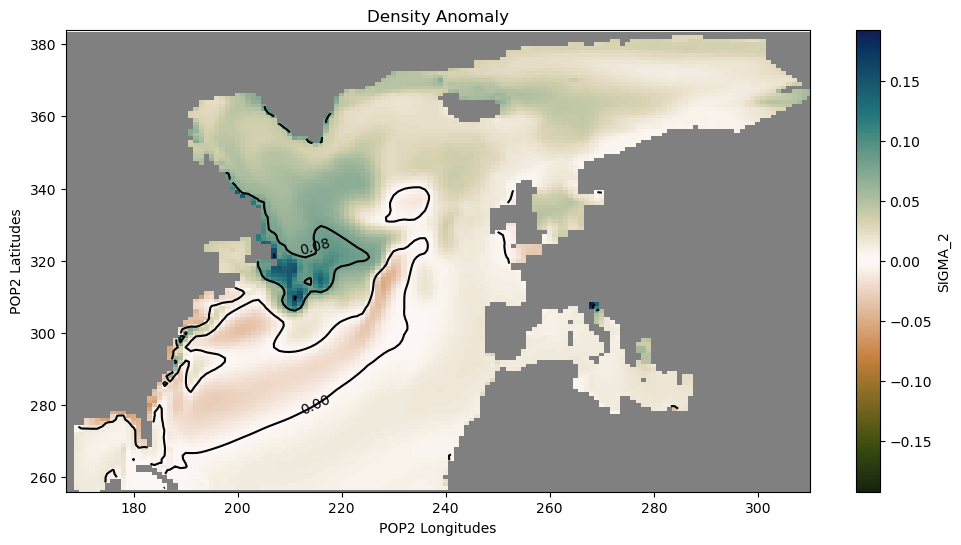

In [149]:
field = difference_sigma.SIGMA_2.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t')

cmap = cmo.tarn
cmap.set_bad('gray')

plt.figure(figsize=(12, 6))
horiz_sigma_plot = field.plot(cmap=cmo.tarn)#, vmin=vmin_sigma, vmax=vmax_sigma)
contour_sigma = field.plot.contour(colors='k') 
plt.clabel(contour_sigma, inline=False, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Density Anomaly')
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'sigma_anomaly-POP.png', bbox_inches='tight', dpi=300)

#### latitudinal section

In [131]:
field = difference_sigma.SIGMA_2.isel(nlon=230)
cmap = cmo.tarn
cmap.set_bad('gray')

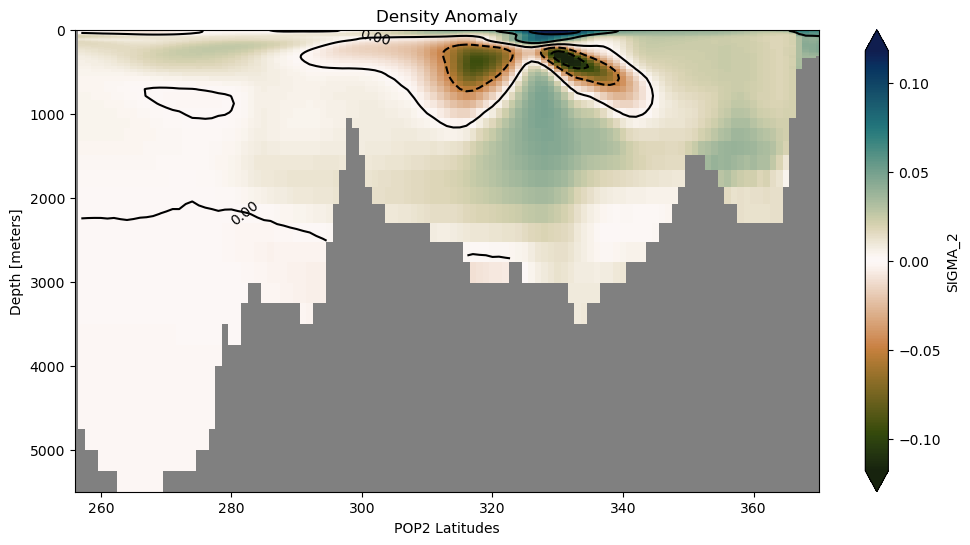

In [133]:
plt.figure(figsize=(12, 6))
lati_sigma_plot = field.plot(cmap=cmap,yincrease=False, vmin=vmin, vmax=vmax)
contour = field.plot.contour(colors='k') 
plt.clabel(contour, inline=False, fontsize=10)

plt.xlim([256, 370])
plt.ylabel('Depth [meters]')
plt.xlabel('POP2 Latitudes')
plt.title('Density Anomaly')

plt.gca().invert_yaxis()
new_y_labels = ['0','1000', '2000', '3000', '4000', '5000']
plt.yticks([0,100000, 200000, 300000, 400000, 500000], labels=new_y_labels)

#plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'sigma_vert_anomaly-cartopy.png', bbox_inches='tight', dpi=300)
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'sigma_vert_anomaly-POP.png', bbox_inches='tight', dpi=300)

### SHF

### Focus Plot

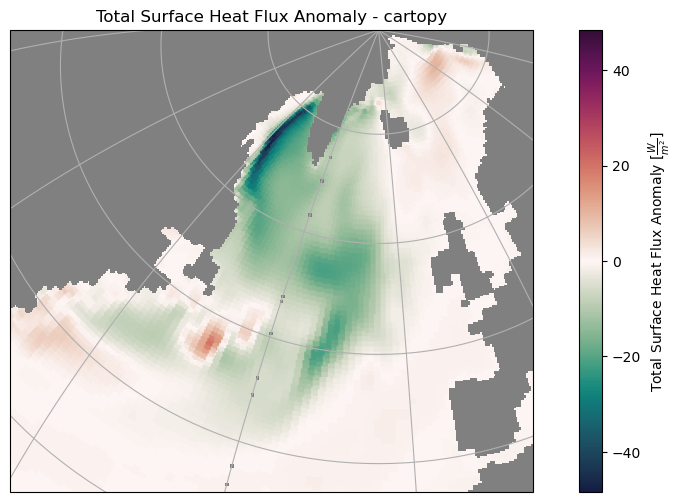

In [114]:
shf_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/shf_anomaly.nc'
difference_shf = xr.open_dataset(shf_file)
vmin = -abs(difference_shf.SHF).max()
vmax = abs(difference_shf.SHF).max()

field = difference_shf.SHF.roll(nlon=+100)
extent = [-35, 40, 45, 90]
cmap = cmo.curl
cmap.set_bad('gray')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Orthographic(20, 65))
ax.set_global()
ax.gridlines()

cs = ax.imshow(field, extent=(difference_shf.TLONG.min(), difference_shf.TLONG.max(), difference_shf.TLAT.min(), difference_shf.TLAT.max()),
               origin='lower', transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_extent(extent)
cbar = plt.colorbar(cs, label=r'Total Surface Heat Flux Anomaly [$\frac{W}{m^2}$]')
plt.title('Total Surface Heat Flux Anomaly - cartopy')

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'shf_anomaly-cartopy.png', bbox_inches='tight', dpi=300)

#### Simple Plot

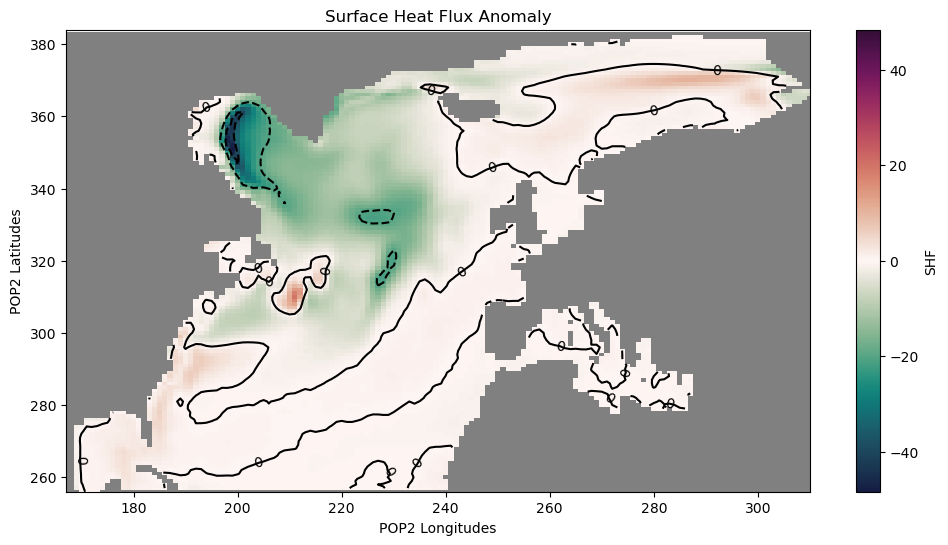

In [116]:
field = difference_shf.SHF

cmap = cmo.curl
cmap.set_bad('gray')

plt.figure(figsize=(12, 6))
shf_plot = field.plot(cmap=cmap, vmin=vmin, vmax=vmax)
contour_shf = field.plot.contour(colors='k') 
plt.clabel(contour_shf, inline=False, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Surface Heat Flux Anomaly')
#plt.show()

plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'shf_anomaly-POP.png', bbox_inches='tight', dpi=300)

### HMXL

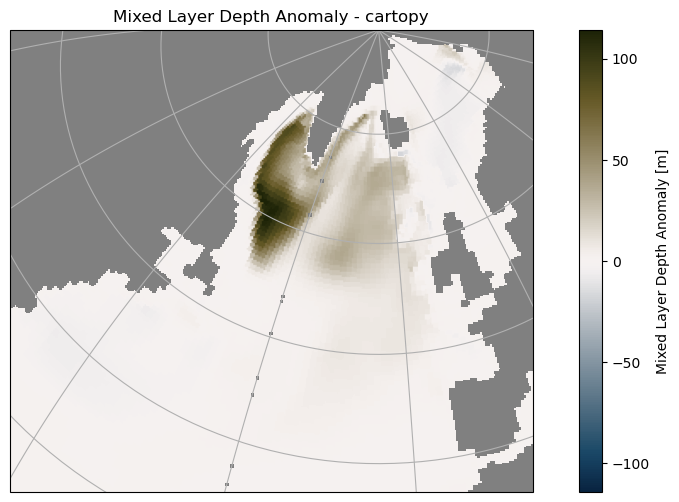

In [125]:
hmxl_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/hmxl_anomaly.nc'
difference_hmxl = xr.open_dataset(hmxl_file)
vmin = -abs(difference_hmxl.HMXL).max()
vmax = abs(difference_hmxl.HMXL).max()

field = difference_hmxl.HMXL.roll(nlon=+100)
extent = [-35, 40, 45, 90]
cmap = cmo.diff
cmap.set_bad('gray')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Orthographic(20, 65))
ax.set_global()
ax.gridlines()

cs = ax.imshow(field, extent=(difference_hmxl.TLONG.min(), difference_hmxl.TLONG.max(), difference_hmxl.TLAT.min(), difference_hmxl.TLAT.max()),
               origin='lower', transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_extent(extent)
cbar = plt.colorbar(cs, label=r'Mixed Layer Depth Anomaly [m]')
plt.title('Mixed Layer Depth Anomaly - cartopy')

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'hmxl_anomaly-cartopy.png', bbox_inches='tight', dpi=300)

### Simple plot

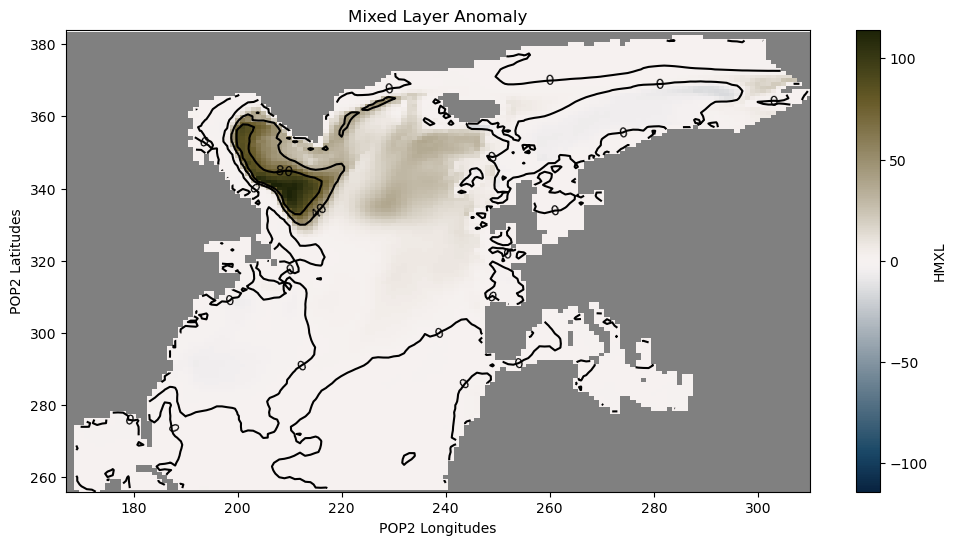

In [126]:
field = difference_hmxl.HMXL

cmap = cmo.diff
cmap.set_bad('gray')

plt.figure(figsize=(12, 6))
difference_hmxl_plot = field.plot(cmap=cmap)#, vmin=vmin_hmxl, vmax=vmax_hmxl)
contour_hmxl = field.plot.contour(colors='k') 
plt.clabel(contour_hmxl, inline=False, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Mixed Layer Anomaly')
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'hmxl_anomaly-POP.png', bbox_inches='tight', dpi=300)

### SSH

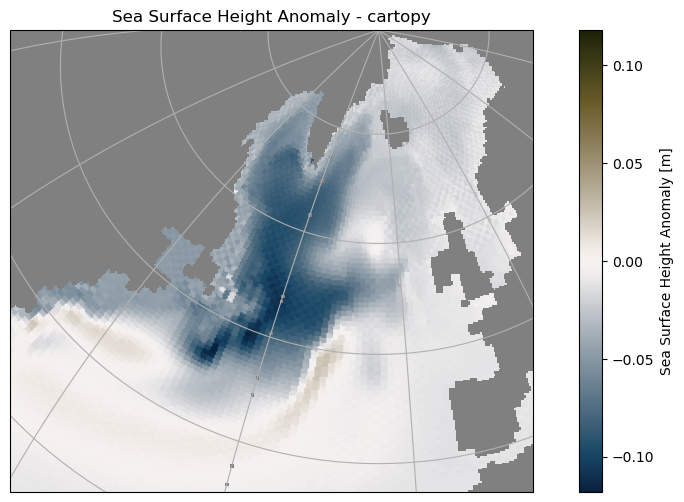

In [127]:
ssh_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/ssh_anomaly.nc'
difference_ssh = xr.open_dataset(ssh_file)
vmin = -abs(difference_ssh.SSH).max()
vmax = abs(difference_ssh.SSH).max()

field = difference_ssh.SSH.roll(nlon=+100)
extent = [-35, 40, 45, 90]
cmap = cmo.diff
cmap.set_bad('gray')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Orthographic(20, 65))
ax.set_global()
ax.gridlines()

cs = ax.imshow(field, extent=(difference_ssh.TLONG.min(), difference_ssh.TLONG.max(), difference_ssh.TLAT.min(), difference_ssh.TLAT.max()),
               origin='lower', transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_extent(extent)
cbar = plt.colorbar(cs, label=r'Sea Surface Height Anomaly [m]')
plt.title('Sea Surface Height Anomaly - cartopy')

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'ssh_anomaly-cartopy.png', bbox_inches='tight', dpi=300)

### Simple Plot

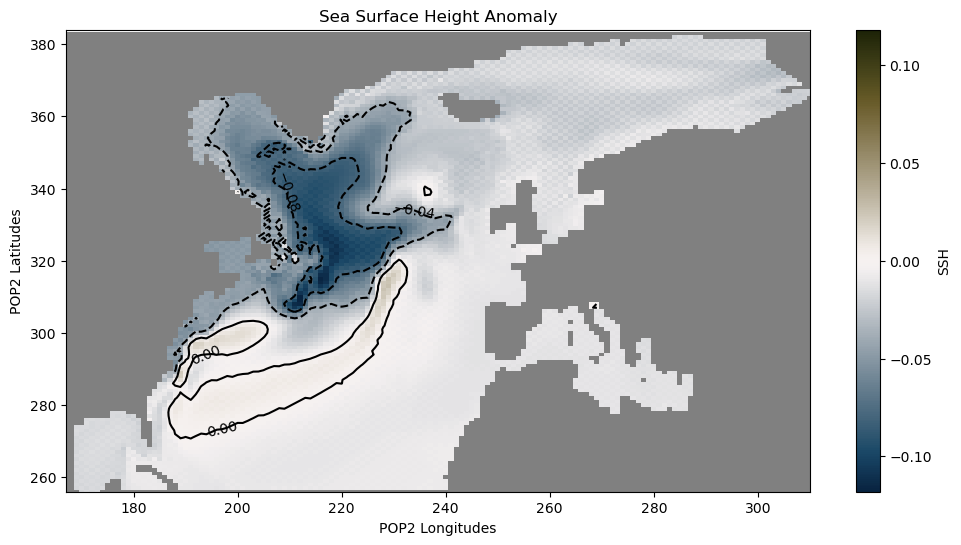

In [129]:
field = difference_ssh.SSH

cmap = cmo.diff
cmap.set_bad('gray')

plt.figure(figsize=(12, 6))
difference_ssh_plot = field.plot(cmap=cmap)#, vmin=vmin_ssh, vmax=vmax_ssh)
contour_ssh = field.plot.contour(colors='k') 
plt.clabel(contour_ssh, inline=False, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Sea Surface Height Anomaly')
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'ssh_anomaly-POP.png', bbox_inches='tight', dpi=300)